# Word2Vec: A language model implementation

In this notebook we will implement a popular machine learning model (word2vec) to obtain word embeddings. 

**We will:**
* Get and preprocess a dataset
* Formulate the Word2Vec task, and create input/label pairs according to the task
* Implement the Word2Vec model in Keras 
* Implement the training loop, train the model
* Save and load the model
* Perform dimensionality reduction to inspect model embeddings
* Implement ranking functionality to inspect model embeddings

## Diagrams to understand Word2Vec

___________
Word2Vec task formulation (how to form training examples)

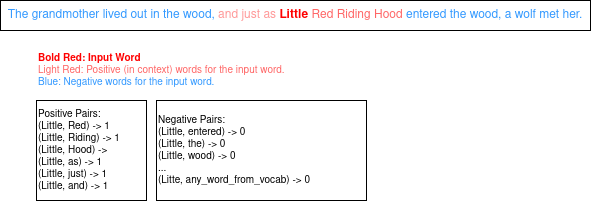

_______

Word2Vec model architecture

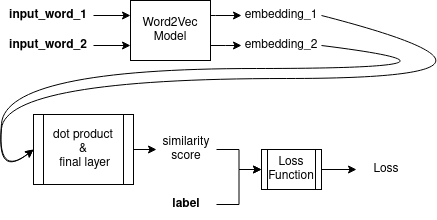

_____

## Data Preprocessing

In [4]:
import keras
import requests
import zipfile
from tqdm import tqdm
from collections import Counter
import numpy as np

from keras.models import Model
from keras.layers import Input, Dense, Reshape, dot
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import sequence

import tensorflow as tf
tf.config.run_functions_eagerly(True)


First, we download and extract the dataset we will be using.

In [5]:
def download_data():
    url = "http://mattmahoney.net/dc/text8.zip"
    r = requests.get(url, stream=True)
    
    bar = tqdm (
        total = int(r.headers["Content-Length"]),
        initial = 0,
        unit = 'B',
        unit_scale = True,
    )
    
    with open("data.zip", "wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                bar.update(1024)
    bar.close()

In [6]:
def extract_data():
    zipfile.ZipFile("data.zip").extractall()

We get all of the words from our corpus file.

In [7]:
def fetch_words():
    words = []
    with open("text8", "r") as f:
        for line in f:
            for word in line.strip().split(" "):
                words.append(word)
                
    return words

Now we need to find the frequency of each word. 

We pick most frequent words (number of words = n_words below) and then we tokenize them. Tokenization is a indexing process. 

We also create reverse indexes to convert integer-type predictions to strings.


More technically: 
Indexing means a hash-table or dictionary where key is the word and reverse indexing is a hash-table where key is the index and value is the word. This is a one to one and onto relation. 



In addition, since we picked frequent words at start, not so frequent words will be labelled as "UNKNOWN", since we have little examples on them. These words might be person names, rarely used words, or other proper nouns like city names, country names...


In [8]:
def build_data(words, n_words):
    freq = [['UNKNOWN', -1]]
    
    c = Counter(words)
    pairs = list(c.items())
    pairs_filtered = sorted(pairs, key=lambda x: -x[1])[:n_words-1] 
    for word, count in pairs_filtered: 
        freq.append([word, count])
        
    dictionary = dict()
    for word, _ in freq:
        dictionary[word] = len(dictionary)
        
    data = list()
    unknown_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNKNOWN']
            unknown_count += 1
        data.append(index)
        
    freq[0][1] = unknown_count
    
    inverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, freq, dictionary, inverse_dictionary

We call our functions and retrieve processed word data.

In [9]:
download_data()
extract_data()
words = fetch_words()

vector_dim = 300
epochs = 200000
vocabulary_upper_limit = 10000
data, freq, dictionary, inverse_dictionary = build_data(words, vocabulary_upper_limit)

31.3MB [00:34, 917kB/s]                            


## Task Formulation

### Word2Vec Task: Skipgrams

A skipgram is where you get one word from a sentence inside your corpus, if another selected word is near it. Even though it is simple, skipgram task is an efficient and effective way to do language modelling.

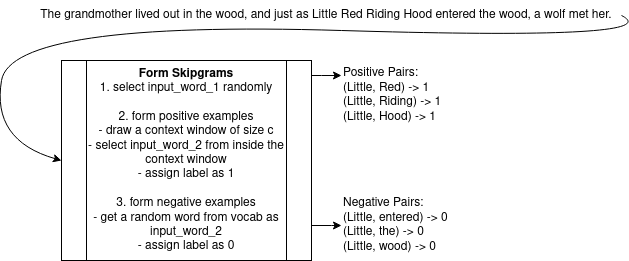

(There is also the CBOW task, which we did not implement here. Check other sources for CBOW task) 

More technically:

A skipgram simply pairs a word with words with a distance of window_size this is a positive lookup and also for outer range pairs it is a negative lookup. Couples are the pairs and label is 1 or 0 according to positive or negative lookup.

In [10]:
sampling_table = sequence.make_sampling_table(vocabulary_upper_limit)
couples, labels = skipgrams(data, vocabulary_upper_limit, window_size=3, sampling_table=sampling_table)
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

Below one can find our model architecture. An embedding layer shared by target and context and later taking their dot product and passing trough a dense layer and output is whether it is a positive lookup or a negative one in other words 1 or 0.

## The Model

- We get the input pair that we've formed, and their label. (are they similar, or not)
- We get the learned embedding value for both of the words
- We perform a dot product operation to measure similarity
- We multiply the dot product results with a weight W, add bias b, then apply sigmoid to get the similarity score.
- We compare the similarity score with the label to calculate loss
- We backpropagate.

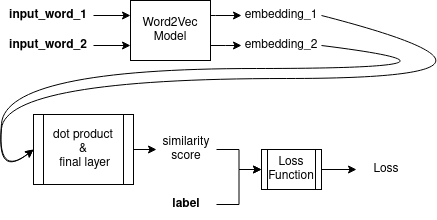

In [11]:
# get input word pair
input_target, input_context = Input(shape=(1)), Input(shape=(1))

# create embedding layer
embedding = Embedding(vocabulary_upper_limit, vector_dim, input_length=1, name='embedding')

# get the embedding for input_word_1
target = embedding(input_target)
target = Reshape((vector_dim, 1))(target)

# get the embedding for input_word_2
context = embedding(input_context)
context = Reshape((vector_dim, 1))(context)

# get the dot product of embedding vectors
dot_product = dot([target, context],  axes=1)
dot_product = Reshape((1,))(dot_product)

# get similarity score with a final transformation
output = Dense(1, activation='sigmoid')(dot_product)

# form and compile model
model = Model(inputs=[input_target, input_context], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam')

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 300)       3000000     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 300, 1)       0           embedding[0][0]              

## Training and Saving the model

**About Word2Vec and embeddings:**
- Word2Vec is one of the most basic methods to obtain word vectors. 
- These word vectors contain information about the meaning of the word, and the vectors can be used by any neural network based NLP model.
- Vectors in Word2Vec are non-contextual. This means that the meaning is not affected by the word's use in sentence.
- Since Word2Vec vectors are non contextual, a typical approach is using a pipeline like Tokenization -> Word2Vec -> BERT , to obtain contextual vectors at the end.
- In the above pipeline, BERT utilizes Word2Vec vectors to infer contextual information and reinterpret the word meanings.
- In most of the NLP frameworks, BERT models include an "Embedding" layer, which corresponds to a Word2Vec unit, just as we have described above.

**Advantages and Disadvantages of Word2Vec:**
- Advantage: It is simple to implement and understand.
- Advantage: It is a good performance method to obtain word embeddings.
- Advantage: It is much, much faster than BERT based methods.
- Disadvantage: It does not include contextual information in word vectors. Word2Vec basically memorizes word meanings, it's a lookup table after the training.

________

We train the model. While doing so:
* We use a batch size of 4096. This means we'll backpropagate and update the weights based upon 4096 examples, in each training step.
* We have about 30 million training examples, making 7327 batches, when divided by 4096.
* We decide to train through the whole dataset for 2 times. (2 epochs)

In [ ]:
batch_size = 4096
epochs = 2
for itr in range(epochs):
    for batch_num in range(len(word_target)//batch_size):
      myslice = slice(batch_num*batch_size,(batch_num+1)*batch_size)
  
      batch_inputs = np.array(word_target[myslice]).reshape(batch_size,1)
      batch_contexts = np.array(word_context[myslice]).reshape(batch_size,1)
      batch_labels = np.array(labels[myslice]).reshape(batch_size,1)

      loss = model.train_on_batch([batch_inputs,batch_contexts],batch_labels)
      print(f"Epoch: {itr}\tBatch Num:{batch_num}/{len(word_target)//batch_size}\tloss={loss}")

We save the model

In [ ]:
#If you use Colab
from google.colab import drive
drive.mount("/content/drive", force_remount=False)

#first, create this folder in your drive
%cd drive/MyDrive/Applied\ AI\ \#4

Mounted at /content/drive
/content/drive/MyDrive/Applied AI #4


In [ ]:
model.save("saved_model.h5")

## Loading the model

We mount the Google Drive. If you're working in local, instead of colab, just skip to the load_model() cell.

In [ ]:
# If you didn't do these already, run this cell

from google.colab import drive
drive.mount("/content/drive", force_remount=False)

# be sure that this folder exists with the model in it
%cd drive/MyDrive/Applied\ AI\ \#4

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Applied AI #4


In [ ]:
!ls

We load the model.

In [ ]:
model = keras.models.load_model("saved_model.h5")

In [ ]:
x = model.weights[0]
weights = x.numpy()
weights.shape

(10000, 300)

## Visualize the language space

To discover how our embedding model behaves, we will draw the embeddings on a plot, in 2D space. 

To do that, we'll be needing to perform dimensionality reduction on the vectors, from 300 dimensions to 2 dimensions.

First, we define a draw function to plot 2D embeddings.

In [ ]:
import matplotlib.pyplot as plt
def draw(subset_representations,words):
  xcor, ycor = zip(*subset_representations)

  fig, ax = plt.subplots()
  ax.scatter(xcor, ycor)

  fig.set_figheight(25)
  fig.set_figwidth(25)

  for i, txt in enumerate(words):
      ax.annotate(txt, (xcor[i], ycor[i]))


### Using TSNE for Dimensionality Reduction

We can use various methods for dimensionality reduction. Here, we use TSNE.

In [ ]:
from sklearn.manifold import TSNE
words = ['man','woman','girl','boy','prince','princess','doctor','teacher', 'scientist','president' ]
word_ids = [dictionary[word] for word in words]
encoded_representations_tsne = TSNE(n_components = 2).fit_transform(weights)[:,:2]

subset_representations_tsne = [encoded_representations_tsne[i] for i in word_ids]
subset_representations_tsne

[array([-23.580044,   8.045821], dtype=float32),
 array([-23.569199,   8.258431], dtype=float32),
 array([-23.808876,   8.716547], dtype=float32),
 array([-24.112968,   8.873793], dtype=float32),
 array([-47.708126, -24.905588], dtype=float32),
 array([-47.634132, -24.561806], dtype=float32),
 array([-45.4986  ,  -9.794881], dtype=float32),
 array([ -7.1043725, -22.132996 ], dtype=float32),
 array([-58.93218 , -15.576801], dtype=float32),
 array([  6.4266267, -24.080744 ], dtype=float32)]

In [ ]:
draw(subset_representations_tsne, words)

### Using PCA for Dimensionality Reduction

Another method for dimensionality reduction is PCA. Here, we use PCA and draw the results.

In [ ]:
from sklearn.decomposition import PCA

words = ["degree","develop","hair","false","daughter","beef","thought","realize","examine","many","route","wilderness","iron","actually","science","jail","busy","pocket","unusual","chemical","promise","flavor","regular","flesh","miss","volcano","back","engine","tree","expansion","deliver","servant","marble","perform","preserve","crowd","steel","electric","sick","happen","enormous","own","team","probable","kiss","flood","capable","shoes","top","strange","death","cat","rate","cats","observation","concerned","minister","kill","hour","tested","white","willing","lying","smoke","cow","steam","invention","type","jam","slave","rest","listen","picture","wind","compete","influence","encourage","writing","detect","mouth","practice","escape","minute","ocean","design","insurance","wide","guitar","rapid","succeed","rabbit","order","strengthen","teaching","stick","swift","necessary","remain","hunt","seed","mere","kick","interest","report","spiritual","old","dinner","wet","open","colour","animated","ghost","damaged","decay","unite","thumb","mighty","cruel","earthquake","blow","part","plan","beam","pack","walk","thread","economic","plants","leg","friend","coil","seal","guard","stem","nine","dust","imperfect","rule","purpose","scientific","paper","land","peel","numerous","trace","curve","suspect","morning","vessel","selection","used","late","time","snow","division","liquid","huge","attempt","salt","wool","trail","knife","sudden","better","amount","winter","account","ink","object","famous","base","accept","visit","orange","grandmother","current","dam","treat","company","shelter","summer","reach","proud","girl","meal","pen","road","powerful","fast","second","fix","shelf","water","fill","marked","hands","fair","question","voice","advice","bell","synonymous","crazy","internal","force","weight","glorious","action","warm","wealthy","permit","lock","creator","cheap","ship","size","selective","tour","shut","double","bear","channel","machine","fact","waiting","structure","letters","dangerous","sink","crime","credit","oil","pleasant","dark","robust","hospital","married","bare","request","business","week","literate","familiar","things","frame","lucky","uncle","mask","bitter","discover","metal","noise","thin","average","previous","polish","phone","keen","page","nerve","matter","growth","fine","van","military","run","eight","dinosaurs","furniture","party","system","racial","telephone","secretary","amazing","farm","fixed","challenge","face","lake","baseball","reign","excellent","fail","children","friction","touch","throne","damage","broad","downtown","sister","trees","ring","mixed","turkey","observe","punch","pump","massive","best","wound","general","check","planes","right","crack","pan","present","tiger","grip","welcome","story","valuable","swing","troubled","magical","marry","modern","use","protective","impossible","call","young","anger","blood","brave","blue","early","real","mind","army","satisfy","identify","common","launch","switch","cemetery","trade","cast","rural","joke","organic","balance","spell","brown","wax","live","skin","poison","dream","desire","glass","stage","afford","bang","level","handle","able","expand","space","approval","ill","peace","impulse","slope","trap","sleep","boiling","bolt","plant","brass","silent","available","romantic","sticks","rainy","finger","decision","passenger","effect","support","damaging","plane","duck","books","rat","fall","copper","meat","program","home","start","brick","governor","expert","club","eyes","bow","loud","serious","payment","woman","smooth","exist","house","desert","precious","careful","agreement","return","ad","hoc","blind","powder","turn","answer","pig","history","faithful","obtain","rock","wood","hat","possess","grade","bottle","medical","exercise","nest","actor","baby","file","loose","spy","safe","tongue","island","gray","pop","potato","airplane","board","dead","ultra","true","knowing","dynamic","arithmetic","material","relation","muscle","minor","employ","steady","large","rings","scattered","argument","print","spring","dry","cold","transport","divide","humorous","rain","arm","prose","various","knowledge","long","day","floor","bridge","connect","bore","collect","debt","battle","attractive","calendar","avoid","card","compare","chance","food","cook","guarantee","typical","serve","branch","communicate","doctor","distribution","year","provide","sort","hate","knock","improve","dogs","unique","market","birds","sky","periodic","light"]
word_ids = [dictionary[word] for word in words]

pca = PCA(2)
encoded_representations_pca = pca.fit_transform(X = weights)

subset_representations_pca = [encoded_representations_pca[i] for i in word_ids]
np.shape(subset_representations_pca)

(508, 2)

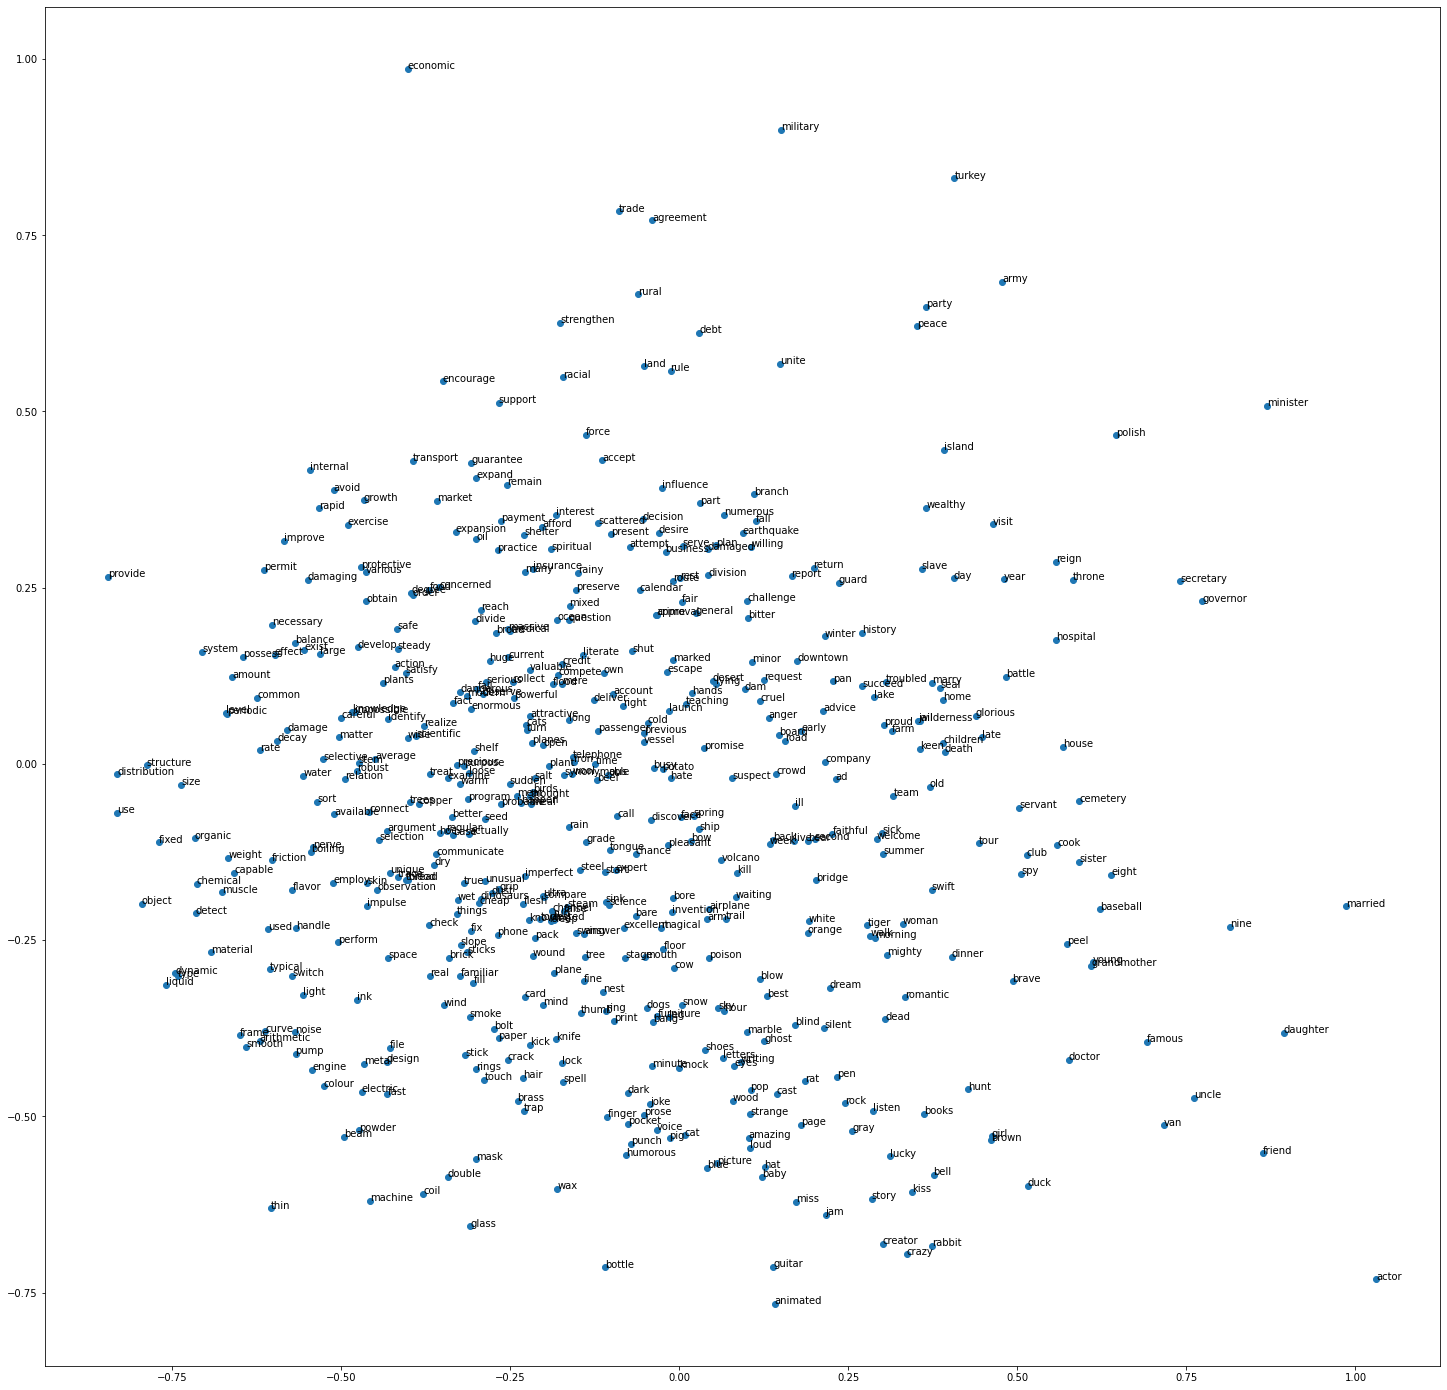

In [ ]:
draw(subset_representations_pca, words)

## Bring the most similar words

To discover how our embedding model behaves in the original 300 dimensional space, we will implement ranking functionality.

* Get embedding of a word from inside our vocabulary
* Retrieve the most similar words to that word
* Print those most similar words

______________

Below we create a model just to use for prediction purposes. It gets the weights of the model that we've trained, and uses the embeddings with dot product to do ranking.

In [ ]:
similarity = dot([target, context], normalize=True, axes=1)
validation_model = Model(inputs=[input_target, input_context], outputs=similarity)


We implement a class to do the ranking.

The class uses run_sim to:

* Get an input word from the vocab as input word
* Use \_get_sim to get similarity scores between our input word and each other word in our vocabulary 
* Rank the scores with argsort
* Print the first 8 similar words

In [ ]:
valid_size = 16 
valid_window = 100
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

class SimilarityCallback:
    def run_sim(self):
        for i in range(valid_size):
            # Get an input word from the vocab as input word
            valid_word = inverse_dictionary[valid_examples[i]]
            top_k = 8  # number of nearest neighbors
            
            # Use \_get_sim to get similarity scores between our input word and each other word in our vocabulary
            sim = self._get_sim(valid_examples[i])
            
            # Rank the scores with argsort
            nearest = (-sim).argsort()[1:top_k + 1]
            
            # Print the first 8 similar words
            log_str = 'Nearest to %s:' % valid_word
            for k in range(top_k):
                close_word = inverse_dictionary[nearest[k]]
                log_str = '%s %s,' % (log_str, close_word)
            print(log_str)

    @staticmethod
    def _get_sim(valid_word_idx):
        sim = np.zeros((vocabulary_upper_limit,))
        in_arr1 = np.zeros((1,))
        in_arr2 = np.zeros((1,))
        in_arr1[0,] = valid_word_idx
        # for each vocab_word in vocab, get the similarity between input word and vocab word
        for i in range(vocabulary_upper_limit):
            in_arr2[0,] = i
            out = validation_model.predict_on_batch([in_arr1, in_arr2])
            sim[i] = out
        return sim

In [ ]:
sim_cb = SimilarityCallback()


In [ ]:
sim_cb.run_sim()

Nearest to two: three, one, zero, five, four, eight, six, seven,
Nearest to many: some, other, these, and, have, such, of, are,
Nearest to their: the, to, and, of, some, in, its, other,
Nearest to also: the, and, of, in, see, as, to, that,
Nearest to as: and, the, of, a, in, is, to, for,
Nearest to is: the, a, and, in, of, was, as, to,
Nearest to not: but, the, and, as, that, would, to, is,
Nearest to or: and, the, of, in, as, a, is, to,
Nearest to while: and, in, the, as, of, or, a, however,
Nearest to UNKNOWN: trail, marketing, famed, actors, fine, pace, screen, keith,
Nearest to a: the, and, of, is, in, as, to, was,
Nearest to be: can, is, are, it, was, may, as, being,
Nearest to during: after, in, was, the, early, since, however, this,
Nearest to th: century, nd, rd, eighth, nineteenth, centuries, twentieth, sixth,
Nearest to first: the, a, in, one, as, and, of, also,
Nearest to system: systems, operating, based, but, also, a, which, is,


## References

https://adventuresinmachinelearning.com/word2vec-keras-tutorial/

https://towardsdatascience.com/a-word2vec-implementation-using-numpy-and-python-d256cf0e5f28

https://medium.com/@zafaralibagh6/a-simple-word2vec-tutorial-61e64e38a6a1